In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import import_helper
import_helper.add_functions()
import neuruloid_segmentation.process_intensities as process

plt.style.use('seaborn-v0_8-bright')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

### From raw intensity dataframes to normalised processed data

Processing raw dataframes (in folder "../intensity_data") for multiple neuruloids of same parameter

- Get maximum distance and make a discretised distance array
- Pass that to process all dataframes individually - normalise by DAPI and cluster intensities by regions of discretise region
- With processed dataframes, normalised signals to 0-1
- Compare this across all neuruloid data

['8hr_iwp_ctrl_350', '8hr_iwp_ctrl_500']


/Users/yitingloo/PhD_projects/posterior_neuruloid_patterning_segmentation/neuruloid_segmentation/process_intensities.py:49: RuntimeWarning: Mean of empty slice
  mean_signal, sd_signal = np.nanmean(signal, axis=0), np.nanstd(signal, axis=0)
/Users/yitingloo/miniforge3/envs/cellpose/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yitingloo/PhD_projects/posterior_neuruloid_patterning_segmentation/neuruloid_segmentation/process_intensities.py:49: RuntimeWarning: Mean of empty slice
  mean_signal, sd_signal = np.nanmean(signal, axis=0), np.nanstd(signal, axis=0)
/Users/yitingloo/miniforge3/envs/cellpose/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


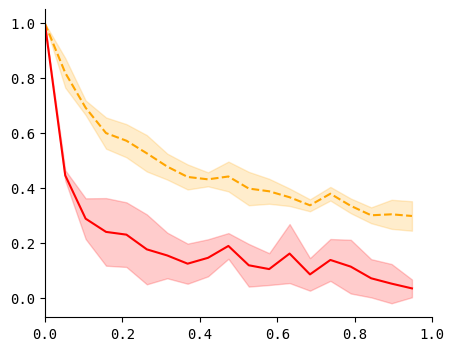

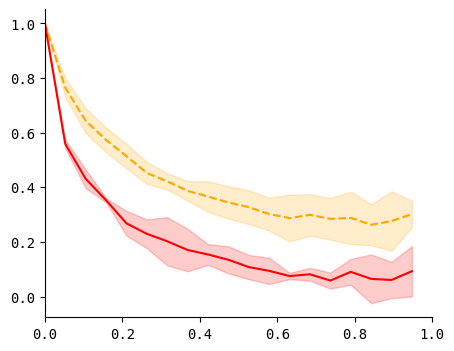

In [2]:
FOLDER = "../intensity_data"
SAVE_FOLDER = "../processed_data"

subfolder = "single_z_slices_early/circle_iwp/8hr_iwp_ctrl"

data_folder_path = os.path.join(FOLDER, subfolder)
data_names = ["8hr_iwp_ctrl_350", "8hr_iwp_ctrl_500"] # sorted(os.listdir(data_folder_path))
print(data_names)

save_folder_path = os.path.join(SAVE_FOLDER, subfolder)
if not os.path.exists(save_folder_path):
    os.mkdir(save_folder_path)

num_discretise = 20
channels, subtract_bg = [2,3], [False,True]

channel_name = {"channel_2":"LEF1", "channel_3":"TBXT"}
channel_color = {"channel_2":"Orange", "channel_3":"Red"}
channel_linestyle = {"channel_2":"--", "channel_3":"-"}

# fig, ax = plt.subplots(1, len(data_names), figsize=(6*len(data_names), 5))

for i in range(len(data_names)):
    fig, ax = plt.subplots(figsize=(5,4))

    data_name = data_names[i]

    dataframes_path = os.path.join(data_folder_path, data_name)
    dataframes_dict = process.process_neuruloids_in_folder(dataframes_path,
                                                           num_discretise,
                                                           channels,
                                                           subtract_bg)

    # plot the signals
    channel_list = list(dataframes_dict.keys())
    for channel_n in channel_list:
        channel_dataframe = dataframes_dict[channel_n]

        discrete_distance_array = channel_dataframe["distance"]
        dist_microns = discrete_distance_array
        norm_dist = dist_microns / np.max(dist_microns)

        save_file_path = os.path.join(save_folder_path, f"{data_name}_{channel_n}.csv")
        mean_signal, sd_signal, n = process.dataframe_to_mean_sd(channel_dataframe,
                                                                 return_full=True,
                                                                 save_path=save_file_path)

        ax.plot(norm_dist, 
                mean_signal, 
                color=channel_color[channel_n], 
                label=f"{channel_name[channel_n]}",
                linestyle=channel_linestyle[channel_n])
        ax.fill_between(norm_dist, 
                        mean_signal+sd_signal, 
                        mean_signal-sd_signal, 
                        color=channel_color[channel_n], 
                        alpha=0.2)

    # ax.set_title(f"{data_name}, n={n}")
    ax.set_xlim(0,1)
    # ax[i].set_xlabel("Distance from edge (microns)")
    # ax[i].set_ylabel("Normalised Intensity")
    # ax[i].legend()
    

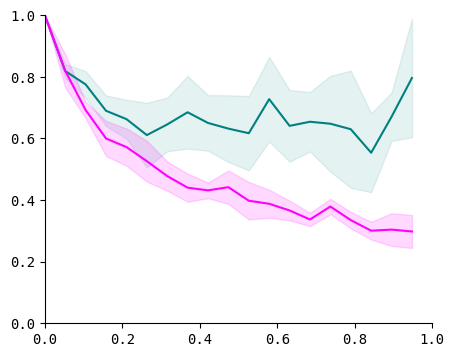

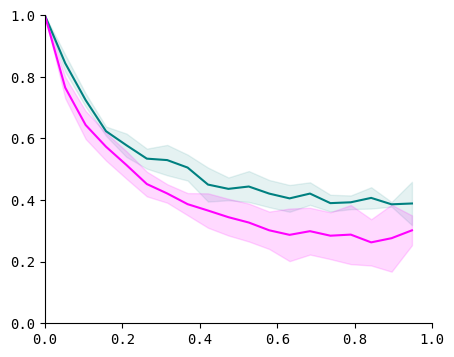

In [3]:
# for IWP experiments, plot control vs iwp treated together
# IWP treated folder
DATA_FOLDER = "../processed_data"
subfolder = "single_z_slices_early/circle_iwp"
datafolder = os.path.join(DATA_FOLDER, subfolder)
iwp_path = os.path.join(datafolder, "8hr_iwp")
control_path = os.path.join(datafolder, "8hr_iwp_ctrl")
sizes = np.array([350, 500])

# fig.suptitle("IWP_experiment_48_hour")

for i in range(len(sizes)):
    fig, ax = plt.subplots(figsize=(5,4))

    iwp_data_file = os.path.join(iwp_path, f"8hr_iwp_{sizes[i]}_channel_2.csv")
    iwp_df = pd.read_csv(iwp_data_file)
    ctrl_data_file = os.path.join(control_path, f"8hr_iwp_ctrl_{sizes[i]}_channel_2.csv")
    ctrl_df = pd.read_csv(ctrl_data_file)

    # ax[i].set_title(sizes[i])
    iwp_norm_distance = iwp_df["distance"] / max(iwp_df["distance"])
    ax.plot(iwp_norm_distance, 
            iwp_df["mean"], 
            color="teal",
            label=f"LEF1 (IWP_treated)",
            linestyle="-")
    ax.fill_between(iwp_norm_distance, 
                    iwp_df["mean"]+iwp_df["sd"], 
                    iwp_df["mean"]-iwp_df["sd"], 
                    color="teal",
                    linestyle="-",
                    alpha=0.1)
    
    ctrl_norm_distance = ctrl_df["distance"] / max(ctrl_df["distance"])
    ax.plot(ctrl_norm_distance, 
            ctrl_df["mean"], 
            color="magenta",
            label=f"LEF1 (control)",
            linestyle="-")
    ax.fill_between(ctrl_norm_distance, 
                    ctrl_df["mean"]+ctrl_df["sd"], 
                    ctrl_df["mean"]-ctrl_df["sd"], 
                    color="magenta",
                    linestyle="-",
                    alpha=0.15)
    
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

# ax[0].legend()

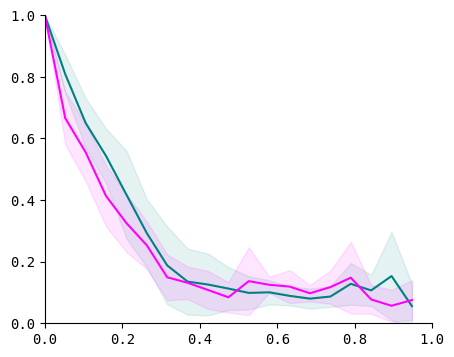

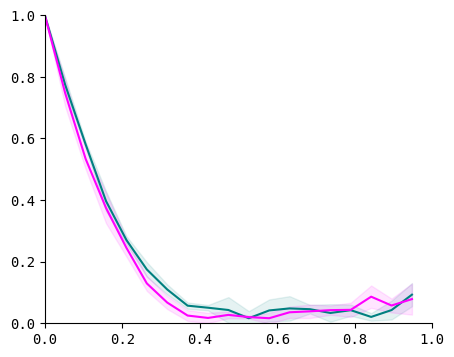

In [4]:
# for IWP experiments, plot control vs iwp treated together
DATA_FOLDER = "../processed_data"
subfolder = "single_z_slices_24hr/circle_IWP_r3" # IWP treated folder
datafolder = os.path.join(DATA_FOLDER, subfolder)
iwp_path = os.path.join(datafolder, "iwp_r3")
control_path = os.path.join(datafolder, "iwp_r3_ctrl")
sizes = np.array([350, 500])

# fig.suptitle("IWP_experiment_48_hour")

for i in range(len(sizes)):
    fig, ax = plt.subplots(figsize=(5,4))

    iwp_data_file = os.path.join(iwp_path, f"iwp_r3_{sizes[i]}_channel_3.csv")
    iwp_df = pd.read_csv(iwp_data_file)
    ctrl_data_file = os.path.join(control_path, f"iwp_r3_ctrl_{sizes[i]}_channel_3.csv")
    ctrl_df = pd.read_csv(ctrl_data_file)

    # ax[i].set_title(sizes[i])
    iwp_norm_distance = iwp_df["distance"] / max(iwp_df["distance"])
    ax.plot(iwp_norm_distance, 
            iwp_df["mean"], 
            color="teal",
            label=f"TBXT (IWP_treated)",
            linestyle="-")
    ax.fill_between(iwp_norm_distance, 
                    iwp_df["mean"]+iwp_df["sd"], 
                    iwp_df["mean"]-iwp_df["sd"], 
                    color="teal",
                    linestyle="-", 
                    alpha=0.1)
    
    ctrl_norm_distance = ctrl_df["distance"] / max(ctrl_df["distance"])
    ax.plot(ctrl_norm_distance, 
            ctrl_df["mean"], 
            color="magenta", 
            label=f"TBXT (control)",
            linestyle="-")
    ax.fill_between(ctrl_norm_distance, 
                    ctrl_df["mean"]+ctrl_df["sd"], 
                    ctrl_df["mean"]-ctrl_df["sd"], 
                    color="magenta",
                    linestyle="-",
                    alpha=0.1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
# ax[0].legend()

### Find the estimate cell density for each neuruloid

Process_20250418_J05_LEFTBXT_8hr_5uMIWP_350_04.csv, 616, TBXT:199
Process_20250418_J05_LEFTBXT_8hr_5uMIWP_350_03.csv, 554, TBXT:55
Process_20250418_J05_LEFTBXT_8hr_5uMIWP_350_02.csv, 619, TBXT:384
Process_20250418_J05_LEFTBXT_8hr_5uMIWP_500_01.csv, 1237, TBXT:732
Process_20250418_J05_LEFTBXT_8hr_5uMIWP_500_02.csv, 1204, TBXT:784
Process_20250418_J05_LEFTBXT_8hr_5uMIWP_500_03.csv, 1221, TBXT:768
Process_20250418_J05_LEFTBXT_8hr_CTRL_350_08.csv, 622, TBXT:444
Process_20250418_J05_LEFTBXT_8hr_CTRL_350_07.csv, 649, TBXT:454
Process_20250418_J05_LEFTBXT_8hr_CTRL_350_06.csv, 651, TBXT:519
Process_20250418_J05_LEFTBXT_8hr_CTRL_500_03.csv, 1237, TBXT:605
Process_20250418_J05_LEFTBXT_8hr_CTRL_500_02.csv, 1244, TBXT:573
Process_20250418_J05_LEFTBXT_8hr_CTRL_500_01.csv, 1240, TBXT:732
Process_20250418_J05_LEFTBXT_8hr_CTRL_500_04.csv, 1274, TBXT:907


(array([[129., 236., 152.,  70.,  21.,   7.,   1.,   0.,   0.,   0.],
        [242., 233.,  59.,  16.,   3.,   0.,   1.,   0.,   0.,   0.],
        [ 24., 156., 206., 132.,  66.,  27.,   4.,   3.,   0.,   1.],
        [ 53., 347., 370., 279., 119.,  50.,  15.,   2.,   1.,   1.],
        [ 30., 286., 376., 276., 147.,  59.,  14.,  16.,   0.,   0.],
        [ 46., 286., 391., 269., 138.,  59.,  23.,   6.,   3.,   0.],
        [ 10., 114., 175., 165.,  85.,  42.,  20.,   7.,   2.,   2.],
        [ 11., 132., 179., 147., 105.,  49.,  13.,   7.,   6.,   0.],
        [  6.,  80., 202., 184.,  98.,  50.,  25.,   3.,   3.,   0.],
        [ 71., 431., 375., 218.,  99.,  31.,  10.,   0.,   2.,   0.],
        [ 92., 454., 388., 188.,  84.,  28.,   7.,   3.,   0.,   0.],
        [ 42., 357., 431., 266., 100.,  35.,   9.,   0.,   0.,   0.],
        [ 26., 232., 438., 339., 166.,  57.,  13.,   3.,   0.,   0.]]),
 array([102.28108108, 123.24136249, 144.20164389, 165.1619253 ,
        186.1222067 , 20

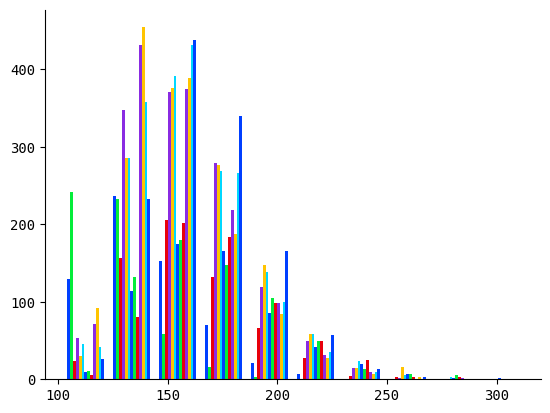

In [5]:
FOLDER = "../intensity_data"
subfolder = "single_z_slices_early/circle_iwp"
data_folder_path = os.path.join(FOLDER, subfolder)
data_names = ["8hr_iwp/8hr_iwp_350", "8hr_iwp/8hr_iwp_500", "8hr_iwp_ctrl/8hr_iwp_ctrl_350", "8hr_iwp_ctrl/8hr_iwp_ctrl_500"] # sorted(os.listdir(data_folder_path))
tbxt_values = []
for i in range(len(data_names)):
    dataframes_path = os.path.join(data_folder_path, data_names[i])
    csv_files = os.listdir(dataframes_path)
    for j in range(len(csv_files)):
        csv_file_path = os.path.join(dataframes_path, csv_files[j])
        df = pd.read_csv(csv_file_path)
        dist = df["distance"].to_numpy()
        tbxt_intensity = df["channel_2"].to_numpy()
        tbxt_positive = tbxt_intensity[tbxt_intensity>150]
        ntbxt = len(tbxt_positive)
        tbxt_values.append(tbxt_intensity)
        ncells = len(df)
        print(f"{csv_files[j]}, {ncells}, TBXT:{ntbxt}")

plt.hist(tbxt_values)

### Plot mean intensities in discrete distance for single neuruloid data

Divide raw signals by dapi signal to normalise since the edge cells have lower signal due to imaging.

Discretise the space, then get mean of nuclei in every discretised space.

In [6]:
# read dataframe
FOLDER = "../intensity_data"
subfolder = "single_z_slices_24hr/circle_ctrl"
data_name = "ctrl_350"
data_folder_path = os.path.join(FOLDER, subfolder)
dataframes_path = os.path.join(data_folder_path, data_name)
dataframe_names = sorted(os.listdir(dataframes_path))
print(dataframe_names)
channel_names = {"channel_1":"DAPI", "channel_2":"LEF1", "channel_3":"TBXT"}

df_path = os.path.join(dataframes_path, dataframe_names[2])
print(df_path)
df = pd.read_csv(df_path)

df.head()


['BestSlice_Process_20240924_JC004-2_24hr_ctrl_30X_350um_05.tif.csv', 'Process_20250310_JC004_3_CTRL_24hr_350um_30X_01.csv', 'Process_20250310_JC004_3_CTRL_24hr_350um_30X_02.csv', 'Process_20250310_JC004_3_CTRL_24hr_350um_30X_04.csv', 'Process_20250310_JC004_3_CTRL_24hr_350um_30X_05.csv']
../intensity_data/single_z_slices_24hr/circle_ctrl/ctrl_350/Process_20250310_JC004_3_CTRL_24hr_350um_30X_02.csv


,Unnamed: 0,cell_id,distance,channel_1,channel_2,channel_3,channel_4
0,0,1,8.787678,484.410663,737.899064,165.970696,334.202686
1,1,2,5.670063,345.621469,486.922034,148.627119,349.251977
2,2,3,6.611975,585.048718,646.684615,184.361538,337.744444
3,3,4,5.398130,486.665094,648.663522,141.226415,231.561321
4,4,5,6.943415,594.401995,905.149127,158.813466,303.156608


In [7]:
normalised_df = process.normalise_channels_by_dapi(df,
                                                   channels=[2,3])
normalised_df.head()

,cell_id,distance,channel_2,channel_3
0,1,8.787678,858.098125,147.058588
1,2,5.670063,780.089728,206.626823
2,3,6.611975,573.262196,128.315175
3,4,5.398130,728.324112,111.325171
4,5,6.943415,857.755424,95.643148


In [8]:
dist_array = np.linspace(0, np.max(df["distance"]), 20)
processed_df = process.mean_intensities(normalised_df,
                                        dist_array,
                                        channels=[2,3])
processed_df.head()

,discrete_distance,cell_number,channel_2_mean,channel_2_sd,channel_3_mean,channel_3_sd
0,7.868980,61.0,624.074781,129.030951,142.751656,42.285991
1,15.737960,66.0,570.015637,115.114482,102.459574,29.020283
2,23.606939,67.0,510.852265,109.361484,95.955106,26.571050
3,31.475919,50.0,432.886267,86.079138,85.467057,21.082295
4,39.344899,53.0,376.792787,87.024158,72.990358,25.933216


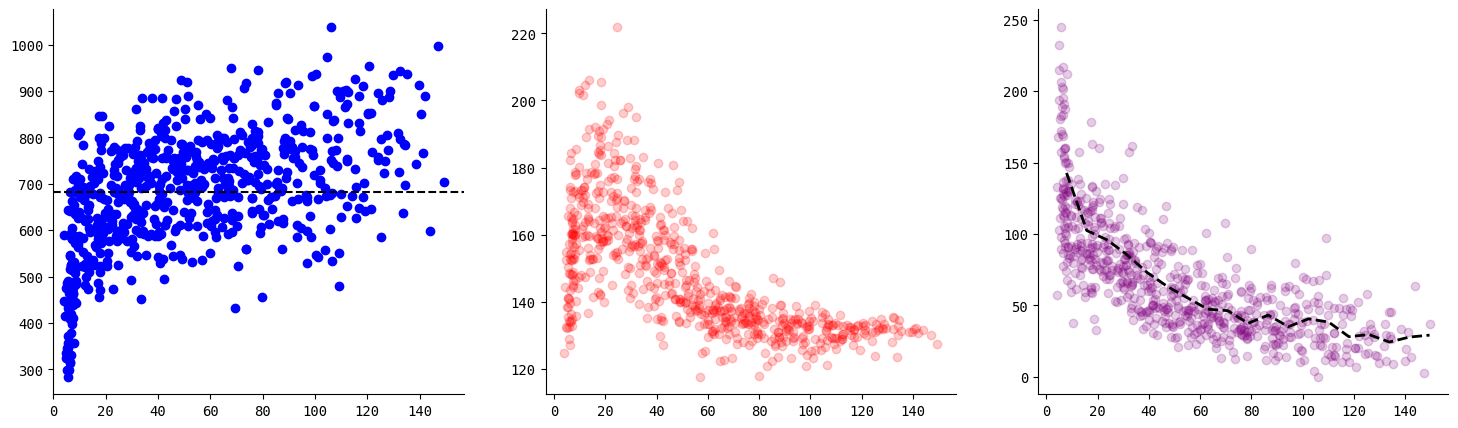

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

nuclei_distance = df["distance"].to_numpy()
discrete_distance = processed_df["discrete_distance"].to_numpy()

dapi = df["channel_1"].to_numpy()
ax[0].scatter(nuclei_distance, dapi, color="blue")
ax[0].axhline(y=np.mean(dapi), color="black", linestyle="--", label="mean")
# ax[0].set_title("DAPI")
ax[0].set_xlim(0)
# ax[0].legend()

tbxt = df["channel_3"].to_numpy()
# tbxt_by_dapi = tbxt *np.mean(dapi) / dapi
ax[1].scatter(nuclei_distance, tbxt, color="Red", alpha=0.2, label="Raw Intensity")
# ax[1].set_title("Raw TBXT Signals")

ax[2].scatter(nuclei_distance, normalised_df["channel_3"], color="Purple", alpha=0.2, label="Normalised Intensity")
# ax[2].errorbar(discrete_distance, 
#                processed_df["channel_3_mean"], 
#                yerr=processed_df["channel_3_sd"],
#                color="black")
ax[2].plot(discrete_distance, processed_df["channel_3_mean"], color="black", linestyle="--", linewidth=2, label="mean by discretised distance")
# ax[2].fill_between(discrete_distance, 
#                    processed_df["channel_3_mean"]-processed_df["channel_3_sd"],
#                    processed_df["channel_3_mean"]+processed_df["channel_3_sd"],
#                    color="black",
#                    alpha=0.1)
# ax[2].set_title("TBXT Signal normalised by DAPI")
# ax[2].legend()


# ax[2].scatter(nuclei_distance, df["channel_2"], color="Green", alpha=0.2)
# ax[2].scatter(nuclei_distance, normalised_df["channel_2"], color="Purple", alpha=0.2)
# ax[2].errorbar(discrete_distance, 
#                processed_df["channel_2_mean"], 
#                yerr=processed_df["channel_2_sd"],
#                color="black")
# ax[2].set_title("LEF1")
